In [1]:
%matplotlib inline

# Imports
import gc
import matplotlib.pyplot as plt
import os
import statsmodels.stats.proportion
import sklearn.pipeline

# seaborn
import seaborn
seaborn.set()
seaborn.set_style("darkgrid")

# Project imports
from legacy_model import *

In [2]:
# Get raw data
raw_data = get_raw_scdb_data("../data/input/SCDB_Legacy_01_justiceCentered_Citation.csv")

# Get feature data
if os.path.exists("../data/output/feature_data.hdf.gz"):
    print("Loading from HDF5 cache")
    feature_df = pandas.read_hdf("../data/output/feature_data.hdf.gz", "root")
else:
    # Process
    feature_df = preprocess_raw_data(raw_data, include_direction=True)
    
    # Write out feature datas
    feature_df.to_hdf("../data/output/feature_data.hdf.gz", "root", complevel=6, complib="zlib")

Loading from HDF5 cache


In [3]:
# Downsample to float
feature_df = feature_df.astype(numpy.float16)

In [4]:
# Remove term
nonterm_features = [f for f in feature_df.columns if not f.startswith("term_")]
original_feature_df = feature_df.copy()
feature_df = original_feature_df.loc[:, nonterm_features].copy()
gc.collect()

611

In [5]:
# Output some diagnostics on features
print(raw_data.shape)
print(feature_df.shape)
assert(raw_data.shape[0] == feature_df.shape[0])

(249793, 64)
(249793, 1501)


In [ ]:
# Reset output file timestamp per run
file_timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

# Reset seed per run
numpy.random.seed(0)

# Setup training time period
dummy_window = 10
min_training_years = 25
term_range = range(raw_data["term"].min() + min_training_years,
                   raw_data["term"].max() + 1)

# Setting growing random forest parameters
# Number of trees to grow per term
trees_per_term = 5

# Number of trees to begin with
initial_trees = min_training_years * trees_per_term

# Setup model
m = None
term_count = 0
feature_importance_df = pandas.DataFrame()

for term in term_range:
    # Diagnostic output
    print("Term: {0}".format(term))
    term_count += 1
    
    # Setup train and test periods
    train_index = (raw_data.loc[:, "term"] < term).values
    dummy_train_index = ((raw_data.loc[:, "term"] < term) & (raw_data.loc[:, "term"] >= (term-dummy_window))).values
    test_index = (raw_data.loc[:, "term"] == term).values
    if test_index.sum() == 0:
        continue
    
    # Setup train data
    feature_data_train = feature_df.loc[train_index, :]
    target_data_train = (raw_data.loc[train_index, "justice_outcome_disposition"]).astype(int)
    target_data_weights = target_data_train.value_counts() / target_data_train.shape[0]

    # Setup test data
    feature_data_test = feature_df.loc[test_index, :]
    target_data_test = (raw_data.loc[test_index, "justice_outcome_disposition"]).astype(int)
    
    # Check if the justice set has changed
    if set(raw_data.loc[raw_data.loc[:, "term"] == (term-1), "naturalCourt"].unique()) != \
        set(raw_data.loc[raw_data.loc[:, "term"] == (term), "naturalCourt"].unique()):
        # natural Court change; trigger forest fire
        print("Natural court change; rebuilding with {0} trees".format(initial_trees + (term_count * trees_per_term)))
        m = None

    # Build or grow a model depending on initial/reset condition
    if not m:
        # Grow an initial forest
        rf = sklearn.ensemble.RandomForestClassifier(n_estimators=initial_trees + (term_count * trees_per_term),
                                                     class_weight=target_data_weights.to_dict(),
                                                    warm_start=True,
                                                    n_jobs=-1)
        pipeline = sklearn.pipeline.Pipeline([("rf", rf)
                                             ])
        
        search_params = {"rf__min_samples_leaf": [1, 2]}
        m = sklearn.model_selection.GridSearchCV(pipeline, search_params, scoring='accuracy')
    else:
        # Grow the forest by increasing the number of trees (requires warm_start=True)
        m.set_params(estimator__rf__n_estimators=initial_trees + (term_count * trees_per_term))

    # Fit the forest model
    m.fit(feature_data_train,
          target_data_train)
    #print(m.get_params())
    
    # Record feature weights
    current_feature_importance_df = pandas.DataFrame(list(zip(feature_df.columns, m.best_estimator_.steps[-1][-1].feature_importances_)),
                                         columns=["feature", "importance"])
    current_feature_importance_df.loc[:, "term"] = term
    if feature_importance_df.shape[0] == 0:
        feature_importance_df = current_feature_importance_df.copy()
    else:
        feature_importance_df = feature_importance_df.append(current_feature_importance_df.copy())

    # Fit the "dummy" model
    d = sklearn.dummy.DummyClassifier(strategy="most_frequent")
    d.fit(feature_df.loc[dummy_train_index, :],
          (raw_data.loc[dummy_train_index, "justice_outcome_disposition"]).astype(int))
    
    # Perform forest predictions
    raw_data.loc[test_index, "rf_predicted"] = m.predict(feature_data_test)
    
    # Store scores per class
    scores = m.predict_proba(feature_data_test)
    raw_data.loc[test_index, "rf_predicted_score_other"] = scores[:, 0]
    raw_data.loc[test_index, "rf_predicted_score_affirm"] = scores[:, 1]
    raw_data.loc[test_index, "rf_predicted_score_reverse"] = scores[:, 2]
    
    # Store dummy predictions
    raw_data.loc[test_index, "dummy_predicted"] = d.predict(feature_data_test)
    
    #  Clear
    del feature_data_train
    del feature_data_test
    del target_data_train
    del target_data_test
    gc.collect()

Term: 1816
Term: 1817
Term: 1818
Term: 1819
Term: 1820
Term: 1821
Term: 1822
Term: 1823
Term: 1824
Natural court change; rebuilding with 170 trees
Term: 1825
Term: 1826
Term: 1827
Natural court change; rebuilding with 185 trees
Term: 1828
Term: 1829
Term: 1830
Natural court change; rebuilding with 200 trees
Term: 1831


In [9]:
# Evaluation range
evaluation_index = raw_data.loc[:, "term"].isin(term_range)
target_actual = (raw_data.loc[evaluation_index, "justice_outcome_disposition"]).astype(int)
target_predicted = raw_data.loc[evaluation_index, "rf_predicted"].astype(int)
target_dummy = raw_data.loc[evaluation_index, "dummy_predicted"].astype(int)
raw_data.loc[:, "rf_correct"] = numpy.nan
raw_data.loc[:, "dummy_correct"] = numpy.nan
raw_data.loc[evaluation_index, "rf_correct"] = (target_actual == target_predicted).astype(float)
raw_data.loc[evaluation_index, "dummy_correct"] = (target_actual == target_dummy).astype(float)

# Setup reverse testing
reverse_target_actual = (raw_data.loc[evaluation_index, "justice_outcome_disposition"] > 0).astype(int)
reverse_target_predicted = (raw_data.loc[evaluation_index, "rf_predicted"] > 0).astype(int)
reverse_target_dummy = (raw_data.loc[evaluation_index, "dummy_predicted"] > 0).astype(int)
raw_data.loc[:, "rf_reverse_correct"] = numpy.nan
raw_data.loc[:, "dummy_reverse_correct"] = numpy.nan
raw_data.loc[evaluation_index, "rf_reverse_correct"] = (reverse_target_actual == reverse_target_predicted).astype(float)
raw_data.loc[evaluation_index, "dummy_reverse_correct"] = (reverse_target_actual == reverse_target_dummy).astype(float)

### Justice Accuracy - Other/Affirm/Reverse

In [10]:
# Compare model
print("RF model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_predicted))
print(sklearn.metrics.confusion_matrix(target_actual, target_predicted))
print(sklearn.metrics.accuracy_score(target_actual, target_predicted))
print("="*32)
print("")

# Dummy model
print("Dummy model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_dummy))
print(sklearn.metrics.confusion_matrix(target_actual, target_dummy))
print(sklearn.metrics.accuracy_score(target_actual, target_dummy))
print("="*32)
print("")

RF model
             precision    recall  f1-score   support

         -1       0.84      0.59      0.69     39540
          0       0.61      0.79      0.69    113666
          1       0.64      0.48      0.55     93569

avg / total       0.66      0.64      0.64    246775

[[23275 11825  4440]
 [ 2900 89989 20777]
 [ 1649 46824 45096]]
0.64171816432

Dummy model
             precision    recall  f1-score   support

         -1       0.33      0.01      0.02     39540
          0       0.52      0.77      0.62    113666
          1       0.57      0.46      0.51     93569

avg / total       0.50      0.53      0.48    246775

[[  495 31931  7114]
 [  618 87102 25946]
 [  398 49888 43283]]
0.530361665485



### Justice Accuracy - Reverse/Not-Reverse

In [11]:
# Compare model
print("RF model")
print("="*32)
print(sklearn.metrics.classification_report(reverse_target_actual, reverse_target_predicted))
print(sklearn.metrics.confusion_matrix(reverse_target_actual, reverse_target_predicted))
print(sklearn.metrics.accuracy_score(reverse_target_actual, reverse_target_predicted))
print("="*32)
print("")

# Dummy model
print("Dummy model")
print("="*32)
print(sklearn.metrics.classification_report(reverse_target_actual, reverse_target_dummy))
print(sklearn.metrics.confusion_matrix(reverse_target_actual, reverse_target_dummy))
print(sklearn.metrics.accuracy_score(reverse_target_actual, reverse_target_dummy))
print("="*32)
print("")

RF model
             precision    recall  f1-score   support

          0       0.73      0.84      0.78    153206
          1       0.64      0.48      0.55     93569

avg / total       0.69      0.70      0.69    246775

[[127989  25217]
 [ 48473  45096]]
0.701387903961

Dummy model
             precision    recall  f1-score   support

          0       0.70      0.78      0.74    153206
          1       0.57      0.46      0.51     93569

avg / total       0.65      0.66      0.65    246775

[[120146  33060]
 [ 50286  43283]]
0.662259142944



### Justice Accuracy - Baseline and RF, Reverse/Not-Reverse

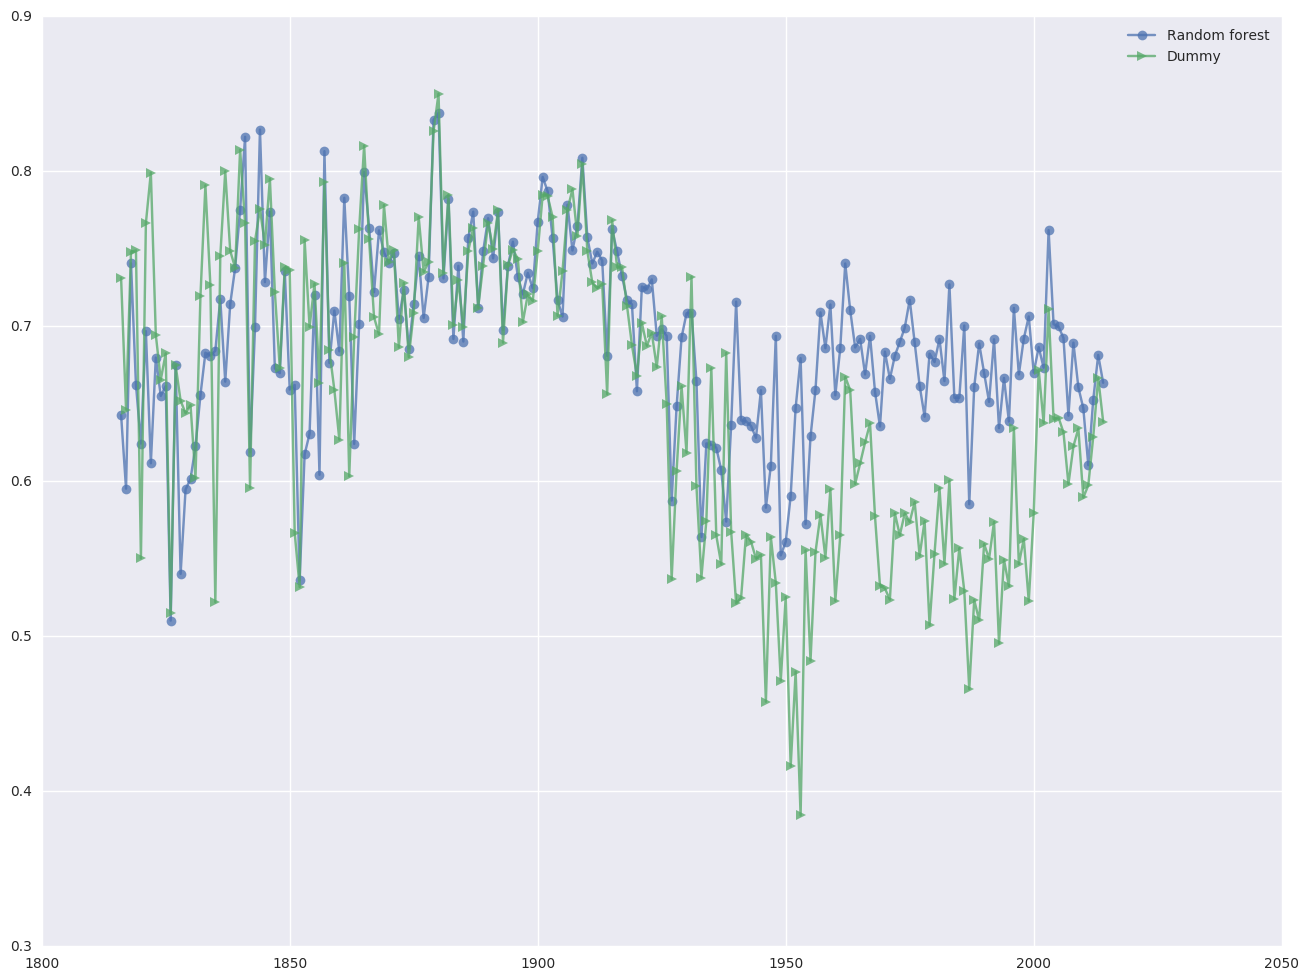

In [12]:
# Setup time series
rf_correct_ts = raw_data.loc[evaluation_index, :].groupby("term")["rf_correct"].mean()
dummy_correct_ts = raw_data.loc[evaluation_index, :].groupby("term")["dummy_correct"].mean()
rf_reverse_correct_ts = raw_data.loc[evaluation_index, :].groupby("term")["rf_reverse_correct"].mean()
dummy_reverse_correct_ts = raw_data.loc[evaluation_index, :].groupby("term")["dummy_reverse_correct"].mean()


# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_reverse_correct_ts.index, rf_reverse_correct_ts,
         marker='o', alpha=0.75)
plt.plot(dummy_reverse_correct_ts.index, dummy_reverse_correct_ts,
         marker='>', alpha=0.75)
plt.legend(('Random forest', 'Dummy'))

### Justice Accuracy - Spread between Baseline and RF

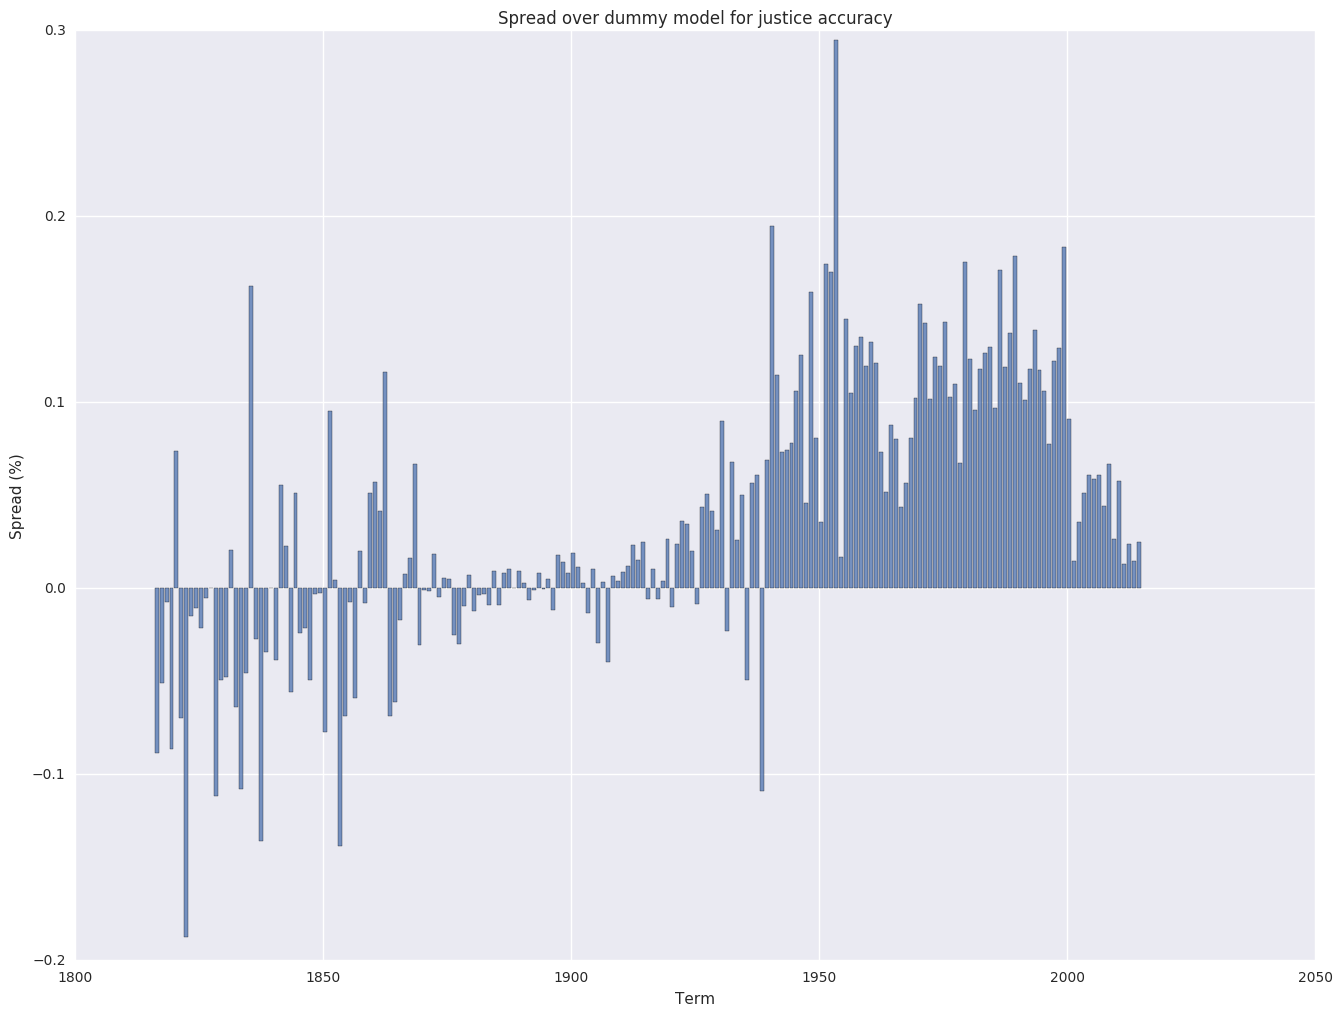

In [13]:
# Setup time series
rf_spread_ts = rf_reverse_correct_ts - dummy_reverse_correct_ts

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.bar(rf_spread_ts.index, rf_spread_ts,
        alpha=0.75)
plt.xlabel("Term")
plt.ylabel("Spread (%)")
plt.title("Spread over dummy model for justice accuracy")

### Statistical Tests - Other/Affirm/Reverse

In [15]:
# Output stats
print("t-test:")
print("Uncalibrated:")
print(scipy.stats.ttest_rel(rf_correct_ts.values,
                   dummy_correct_ts.values))

print("=" * 16)
print("ranksum-test:")
print("Uncalibrated:")
print(scipy.stats.ranksums(rf_correct_ts.values,
                   dummy_correct_ts.values))

print("=" * 16)
print("Binomial:")
print(statsmodels.stats.proportion.binom_test(raw_data.loc[evaluation_index, "rf_correct"].sum(),
                                              raw_data.loc[evaluation_index, "rf_correct"].shape[0],
                                              raw_data.loc[evaluation_index, "dummy_correct"].mean(),
                                              alternative="larger"))

t-test:
Uncalibrated:
Ttest_relResult(statistic=23.272208335478453, pvalue=1.4432447109929565e-58)
ranksum-test:
Uncalibrated:
RanksumsResult(statistic=12.84019928740541, pvalue=9.7622847489511895e-38)
Binomial:
0.0


### Statistical Tests - Reverse/Not-Reverse

In [17]:
# Output stats
print("t-test:")
print("Uncalibrated:")
print(scipy.stats.ttest_rel(rf_reverse_correct_ts.values,
                   dummy_reverse_correct_ts.values))

print("=" * 16)
print("ranksum-test:")
print("Uncalibrated:")
print(scipy.stats.ranksums(rf_reverse_correct_ts.values,
                   dummy_reverse_correct_ts.values))

print("=" * 16)
print("Binomial:")
print(statsmodels.stats.proportion.binom_test(raw_data.loc[evaluation_index, "rf_reverse_correct"].sum(),
                                              raw_data.loc[evaluation_index, "rf_reverse_correct"].shape[0],
                                              raw_data.loc[evaluation_index, "dummy_reverse_correct"].mean(),
                                              alternative="larger"))

t-test:
Uncalibrated:
Ttest_relResult(statistic=7.1213002828932384, pvalue=1.9318063016476262e-11)
ranksum-test:
Uncalibrated:
RanksumsResult(statistic=3.2030780834029176, pvalue=0.0013596710999313262)
Binomial:
0.0


### Sample Feature Weights

In [18]:
# Feature importance
last_feature_importance_df = pandas.DataFrame(list(zip(feature_df.columns, m.best_estimator_.steps[-1][-1].feature_importances_)),
                                         columns=["feature", "importance"])
last_feature_importance_df.sort_values(["importance"], ascending=False).head(10)

,feature,importance
1499,justice_previous_lc_direction_diff,0.032379
1500,justice_cumulative_lc_direction_diff,0.030223
131,decision_delay,0.025805
1495,justice_previous_court_agreement,0.022228
1489,justice_previous_court_action,0.021579
1496,justice_cumulative_court_agreement,0.020348
0,natural_court_raw,0.020005
1490,justice_cumulative_court_action,0.019658
1487,justice_previous_action,0.018539
1483,justice_previous_court_direction,0.017184


# Case Level Analysis

In [19]:
# Get outcomes as reverse/not-reverse for real data
raw_data.loc[:, "justice_outcome_reverse"] = (raw_data.loc[:, "justice_outcome_disposition"] > 0).astype(int)
raw_data.loc[:, "case_outcome_reverse"] = (raw_data.loc[:, "case_outcome_disposition"] > 0).astype(int)

In [39]:
# Store reverse predictions
raw_data.loc[evaluation_index, "rf_predicted_reverse"] = (raw_data.loc[evaluation_index, "rf_predicted"] > 0).astype(int)
raw_data.loc[evaluation_index, "dummy_predicted_reverse"] = (raw_data.loc[evaluation_index, "dummy_predicted"] > 0).astype(int)

# Group by case
rf_predicted_case = (raw_data.loc[evaluation_index, :]\
    .groupby("docketId")["rf_predicted_reverse"].mean() >= 0.5).astype(int)

dummy_predicted_case = (raw_data.loc[evaluation_index, :]\
    .groupby("docketId")["dummy_predicted_reverse"].mean() >= 0.5).astype(int)

actual_case = (raw_data.loc[evaluation_index, :]\
    .groupby("docketId")["case_outcome_reverse"].mean() > 0).astype(int)

In [44]:
# Setup case dataframe
case_data = pandas.DataFrame(rf_predicted_case).join(dummy_predicted_case).join(actual_case)
case_data = case_data.join(raw_data.groupby("docketId")[["term", "naturalCourt"]].mean().astype(int))

# Setup correct columns
case_data.loc[:, "rf_correct_case"] = numpy.nan
case_data.loc[:, "dummy_correct_case"] = numpy.nan
case_data.loc[:, "rf_correct_case"] = (case_data.loc[:, "rf_predicted_reverse"] == case_data.loc[:, "case_outcome_reverse"])\
    .astype(int)
case_data.loc[:, "dummy_correct_case"] = (case_data.loc[:, "dummy_predicted_reverse"] == case_data.loc[:, "case_outcome_reverse"])\
    .astype(int)

# Join back onto raw data
case_data.loc[:, "docketId"] = case_data.index
raw_data = raw_data.join(case_data.loc[:, ["docketId", "rf_correct_case", "dummy_correct_case"]], on="docketId", rsuffix="_case")

### Case Accuracy

In [46]:
# Output comparison
# Evaluation range
evaluation_index = case_data.loc[:, "term"].isin(term_range)
target_actual = case_data.loc[:, "case_outcome_reverse"]
target_predicted = case_data.loc[:, "rf_predicted_reverse"]
target_dummy = case_data.loc[:, "dummy_predicted_reverse"]

# Compare model
print("RF model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_predicted))
print(sklearn.metrics.confusion_matrix(target_actual, target_predicted))
print(sklearn.metrics.accuracy_score(target_actual, target_predicted))
print("="*32)
print("")

# Dummy model
print("Dummy model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_dummy))
print(sklearn.metrics.confusion_matrix(target_actual, target_dummy))
print(sklearn.metrics.accuracy_score(target_actual, target_dummy))
print("="*32)
print("")

RF model
             precision    recall  f1-score   support

          0       0.71      0.83      0.77     16740
          1       0.67      0.50      0.57     11340

avg / total       0.70      0.70      0.69     28080

[[13967  2773]
 [ 5663  5677]]
0.699572649573

Dummy model
             precision    recall  f1-score   support

          0       0.69      0.81      0.75     16740
          1       0.63      0.47      0.54     11340

avg / total       0.67      0.67      0.66     28080

[[13586  3154]
 [ 5974  5366]]
0.674928774929



### Case Accuracy (last century)

In [59]:
# Output comparison
# Evaluation range
last_century = case_data["term"].drop_duplicates().sort_values().tail(100)
evaluation_index = case_data.loc[:, "term"].isin(last_century)
target_actual = case_data.loc[evaluation_index, "case_outcome_reverse"]
target_predicted = case_data.loc[evaluation_index, "rf_predicted_reverse"]
target_dummy = case_data.loc[evaluation_index, "dummy_predicted_reverse"]

# Compare model
print("RF model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_predicted))
print(sklearn.metrics.confusion_matrix(target_actual, target_predicted))
print(sklearn.metrics.accuracy_score(target_actual, target_predicted))
print("="*32)
print("")

# Dummy model
print("Dummy model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_dummy))
print(sklearn.metrics.confusion_matrix(target_actual, target_dummy))
print(sklearn.metrics.accuracy_score(target_actual, target_dummy))
print("="*32)
print("")

RF model
             precision    recall  f1-score   support

          0       0.66      0.65      0.66      6742
          1       0.69      0.69      0.69      7536

avg / total       0.68      0.68      0.68     14278

[[4409 2333]
 [2304 5232]]
0.675234626698

Dummy model
             precision    recall  f1-score   support

          0       0.62      0.53      0.57      6742
          1       0.63      0.71      0.67      7536

avg / total       0.63      0.63      0.62     14278

[[3588 3154]
 [2170 5366]]
0.627118644068



### Case Accuracy (20th century)

In [60]:
# Output comparison
# Evaluation range
last_century = range(1900, 2000)
evaluation_index = case_data.loc[:, "term"].isin(last_century)
target_actual = case_data.loc[evaluation_index, "case_outcome_reverse"]
target_predicted = case_data.loc[evaluation_index, "rf_predicted_reverse"]
target_dummy = case_data.loc[evaluation_index, "dummy_predicted_reverse"]

# Compare model
print("RF model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_predicted))
print(sklearn.metrics.confusion_matrix(target_actual, target_predicted))
print(sklearn.metrics.accuracy_score(target_actual, target_predicted))
print("="*32)
print("")

# Dummy model
print("Dummy model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_dummy))
print(sklearn.metrics.confusion_matrix(target_actual, target_dummy))
print(sklearn.metrics.accuracy_score(target_actual, target_dummy))
print("="*32)
print("")

RF model
             precision    recall  f1-score   support

          0       0.69      0.76      0.72      8748
          1       0.69      0.61      0.64      7531

avg / total       0.69      0.69      0.69     16279

[[6648 2100]
 [2958 4573]]
0.689292954113

Dummy model
             precision    recall  f1-score   support

          0       0.67      0.68      0.67      8748
          1       0.62      0.60      0.61      7531

avg / total       0.64      0.65      0.64     16279

[[5970 2778]
 [3000 4531]]
0.645064193132



### Case Accuracy (19th century)

In [61]:
# Output comparison
# Evaluation range
last_century = range(1816, 1900)
evaluation_index = case_data.loc[:, "term"].isin(last_century)
target_actual = case_data.loc[evaluation_index, "case_outcome_reverse"]
target_predicted = case_data.loc[evaluation_index, "rf_predicted_reverse"]
target_dummy = case_data.loc[evaluation_index, "dummy_predicted_reverse"]

# Compare model
print("RF model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_predicted))
print(sklearn.metrics.confusion_matrix(target_actual, target_predicted))
print(sklearn.metrics.accuracy_score(target_actual, target_predicted))
print("="*32)
print("")

# Dummy model
print("Dummy model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_dummy))
print(sklearn.metrics.confusion_matrix(target_actual, target_dummy))
print(sklearn.metrics.accuracy_score(target_actual, target_dummy))
print("="*32)
print("")

RF model
             precision    recall  f1-score   support

          0       0.73      0.95      0.83      7616
          1       0.48      0.11      0.18      2974

avg / total       0.66      0.72      0.65     10590

[[7255  361]
 [2636  338]]
0.716997167139

Dummy model
             precision    recall  f1-score   support

          0       0.72      1.00      0.84      7616
          1       0.00      0.00      0.00      2974

avg / total       0.52      0.72      0.60     10590

[[7616    0]
 [2974    0]]
0.719169027384



/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Case Accuracy Time Series

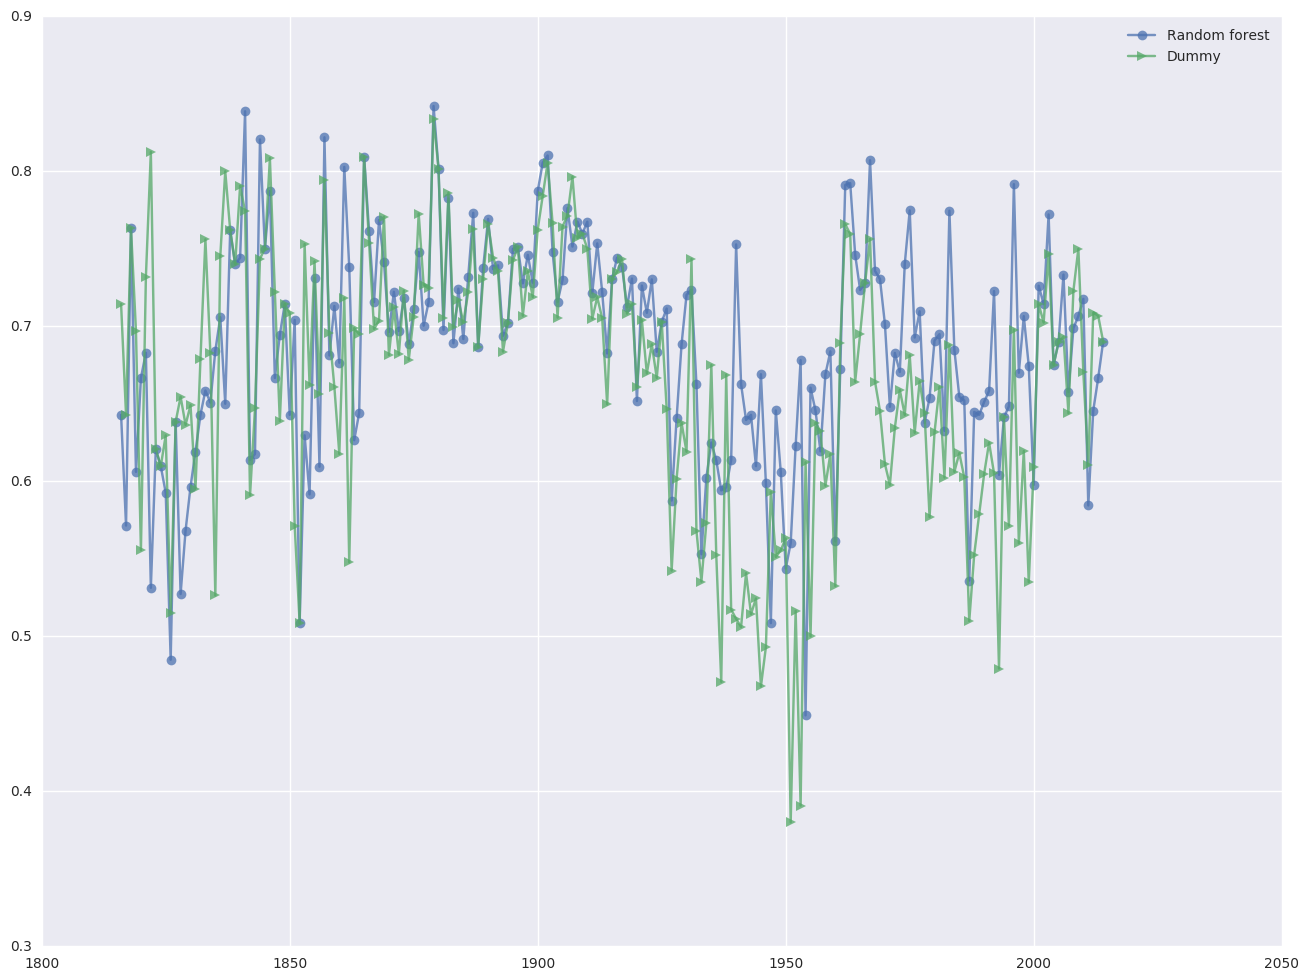

In [47]:
# Setup time series
case_evaluation_index = ~case_data.loc[:, "rf_correct_case"].isnull()
rf_correct_case_ts = case_data.loc[case_evaluation_index, :].groupby("term")["rf_correct_case"].mean()
dummy_correct_case_ts = case_data.loc[case_evaluation_index, :].groupby("term")["dummy_correct_case"].mean()

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_correct_case_ts.index, rf_correct_case_ts,
         marker='o', alpha=0.75)
plt.plot(dummy_correct_case_ts.index, dummy_correct_case_ts,
         marker='>', alpha=0.75)
plt.legend(('Random forest', 'Dummy'))

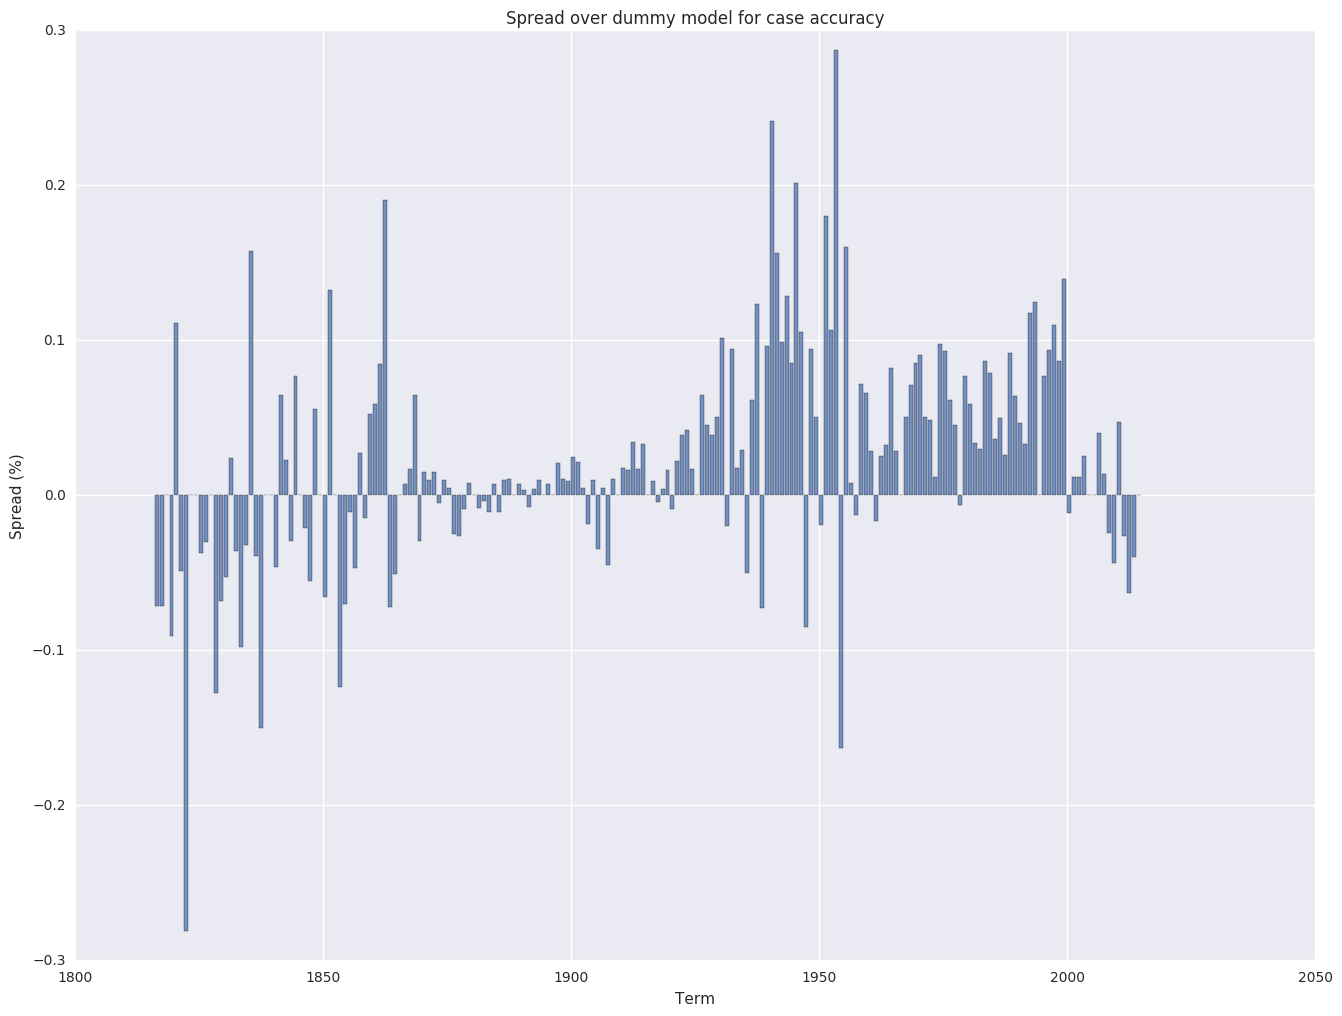

In [48]:
# Setup time series
rf_spread_case_ts = rf_correct_case_ts - dummy_correct_case_ts

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.bar(rf_spread_case_ts.index, rf_spread_case_ts,
        alpha=0.75)
plt.xlabel("Term")
plt.ylabel("Spread (%)")
plt.title("Spread over dummy model for case accuracy")

## Cumulative Term Win/Loss 

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: FutureWarning: pd.expanding_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_periods=1).sum()
  from ipykernel import kernelapp as app


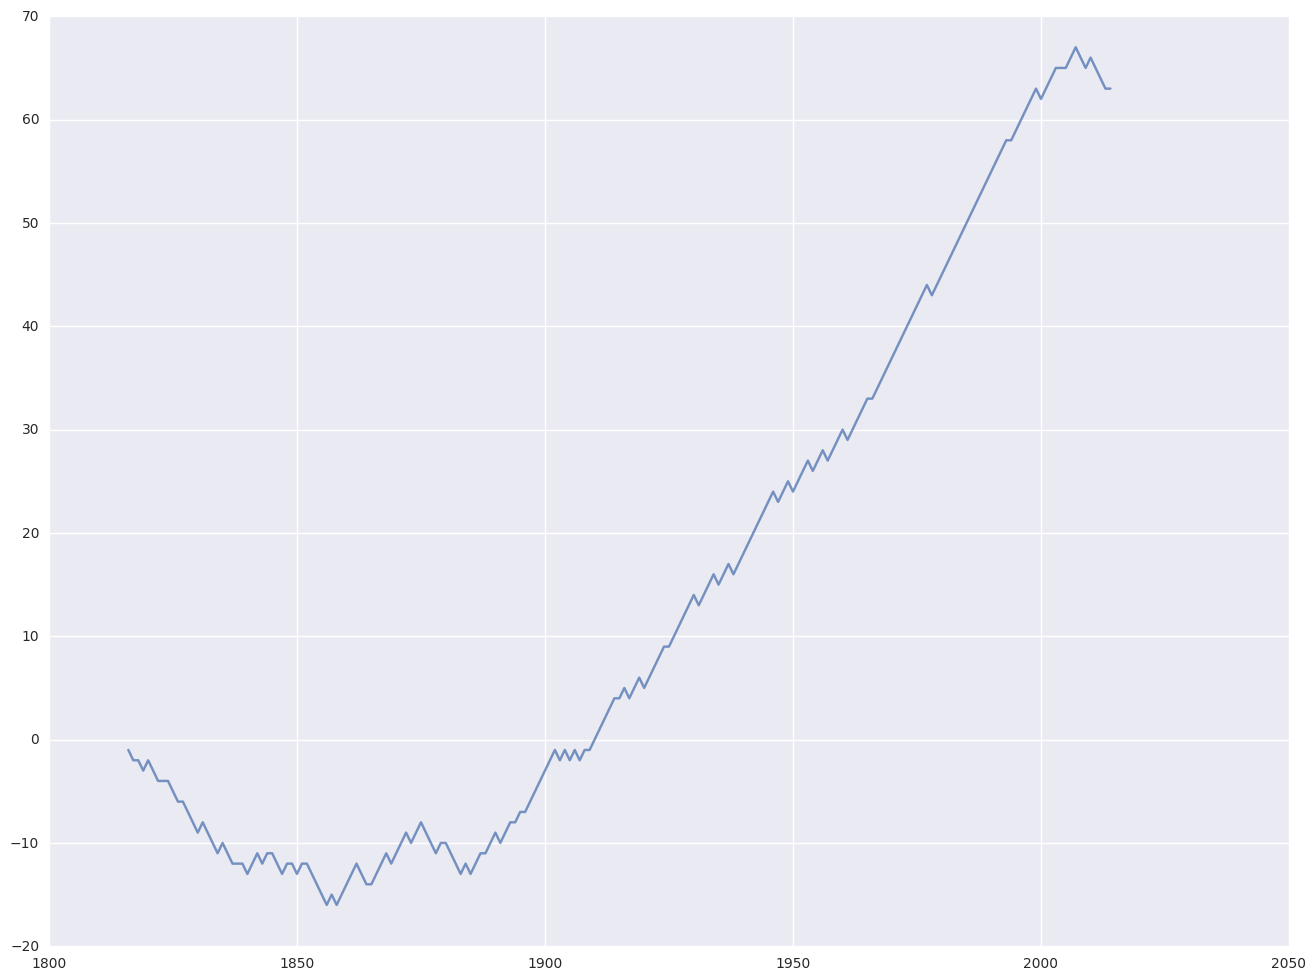

In [49]:
# Setup time series
rf_spread_case_dir_ts = pandas.expanding_sum(numpy.sign(rf_spread_case_ts))

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_spread_case_dir_ts.index, rf_spread_case_dir_ts,
        alpha=0.75)

### Statistical Tests - Case Accuracy (all time)

In [50]:
# Output stats
print("t-test:")
print("Uncalibrated:")
print(scipy.stats.ttest_rel(rf_correct_case_ts.values,
                   dummy_correct_case_ts.values))

print("=" * 16)
print("ranksum-test:")
print("Uncalibrated:")
print(scipy.stats.ranksums(rf_correct_case_ts.values,
                   dummy_correct_case_ts.values))

print("=" * 16)
print("Binomial:")
print(statsmodels.stats.proportion.binom_test(case_data["rf_correct_case"].sum(),
                                              case_data["rf_correct_case"].shape[0],
                                              case_data["dummy_correct_case"].mean(),
                                              alternative="larger"))

t-test:
Uncalibrated:
Ttest_relResult(statistic=4.4045476314279242, pvalue=1.7340164455938339e-05)
ranksum-test:
Uncalibrated:
RanksumsResult(statistic=2.0793209922457789, pvalue=0.037587856918791226)
Binomial:
3.65872863362e-19


### Statistical Tests - Case Accuracy (last century)

In [55]:
# Output stats
print("t-test:")
print("Uncalibrated:")
print(scipy.stats.ttest_rel(rf_correct_case_ts.tail(100).values,
                   dummy_correct_case_ts.tail(100).values))

print("=" * 16)
print("ranksum-test:")
print("Uncalibrated:")
print(scipy.stats.ranksums(rf_correct_case_ts.tail(100).values,
                   dummy_correct_case_ts.tail(100).values))

print("=" * 16)
print("Binomial:")
last_century = case_data["term"].drop_duplicates().sort_values().tail(100)
print(statsmodels.stats.proportion.binom_test(case_data.loc[case_data["term"].isin(last_century), "rf_correct_case"].sum(),
                                              case_data.loc[case_data["term"].isin(last_century), "rf_correct_case"].shape[0],
                                              case_data.loc[case_data["term"].isin(last_century), "dummy_correct_case"].mean(),
                                              alternative="larger"))

t-test:
Uncalibrated:
Ttest_relResult(statistic=7.2687867596920173, pvalue=8.5216959515204817e-11)
ranksum-test:
Uncalibrated:
RanksumsResult(statistic=4.1146668859203599, pvalue=3.8773895023046992e-05)
Binomial:
1.85923794055e-33


### Output Data

In [57]:
# Output file data
raw_data.to_csv("../data/output/raw_docket_justice_model_growing_random_forest_5.csv.gz", compression="gzip")
case_data.to_csv("../data/output/raw_docket_case_model_growing_random_forest_5.csv.gz", compression="gzip")
feature_importance_df.to_csv("../data/output/raw_docket_features_model_growing_random_forest_5.csv.gz", compression="gzip")